In [1]:
# CELL 1: SETUP & LOAD DATA BARU
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Config Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Koneksi ke Tabel BARU (lap_telemetry_clean)
db_config = {
    "host": "postgres-warehouse",
    "port": "5432",
    "database": "f1_datawarehouse",
    "user": "warehouse_user",
    "password": "warehouse_password"
}

conn = psycopg2.connect(**db_config)
# Ambil data lap-level (bukan agregasi)
df = pd.read_sql("SELECT * FROM lap_telemetry_clean", conn)
conn.close()

print(f"Data Loaded: {df.shape[0]} Rows (Data Detail per Lap)")
display(df.head(3))

/tmp/ipykernel_5312/4054721057.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM lap_telemetry_clean", conn)


Data Loaded: 55848 Rows (Data Detail per Lap)


,AirTemp,Avg_Brake_Pressure,Avg_Corner_Speed,Avg_RPM,Circuit,Compound,Driver,EventName,Full_Throttle_Pct,Gear_Changes,...,SpeedI1,SpeedI2,SpeedST,Team,TrackTemp,TyreLife,Year,_id,LapTime_Minutes,Is_High_Speed
0,NaN,1.0,145.779298,9769.327608,Melbourne,ULTRASOFT,HAM,Australian Grand Prix,35.173299,64,...,248.0,270.0,146.0,Mercedes,NaN,1,2018,69274260ddc9b2444e534d18,1.798817,True
1,NaN,1.0,172.049882,10707.407426,Melbourne,ULTRASOFT,HAM,Australian Grand Prix,62.321145,41,...,281.0,290.0,313.0,Mercedes,NaN,2,2018,69274260ddc9b2444e534d19,1.396700,True
2,NaN,1.0,153.670028,9306.332604,Melbourne,ULTRASOFT,HAM,Australian Grand Prix,15.130024,43,...,205.0,254.0,288.0,Mercedes,NaN,3,2018,69274260ddc9b2444e534d1a,1.875600,True



 1. DATA QUALITY CHECK


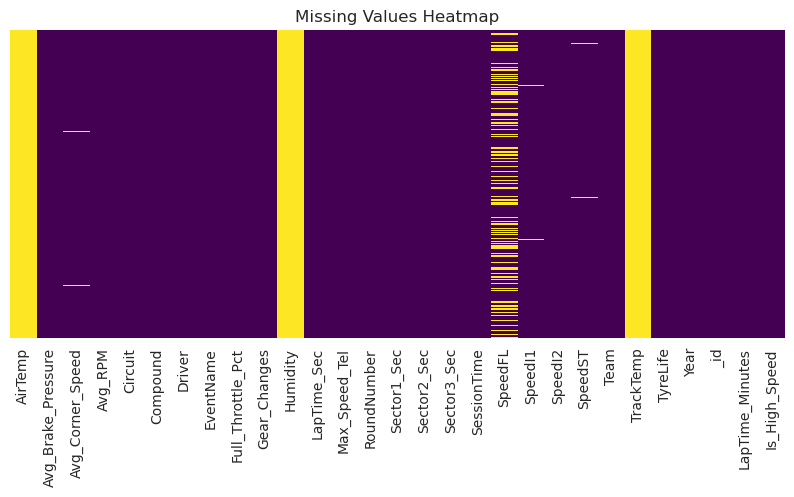

Jumlah Duplikat: 27924


In [3]:
print("\n 1. DATA QUALITY CHECK")

# Missing Values Heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Duplicate Check
duplicate_count = df.duplicated(subset=['Year', 'Circuit', 'Driver', 'SessionTime']).sum()
print(f"Jumlah Duplikat: {duplicate_count}")


 2. UNIVARIATE ANALYSIS


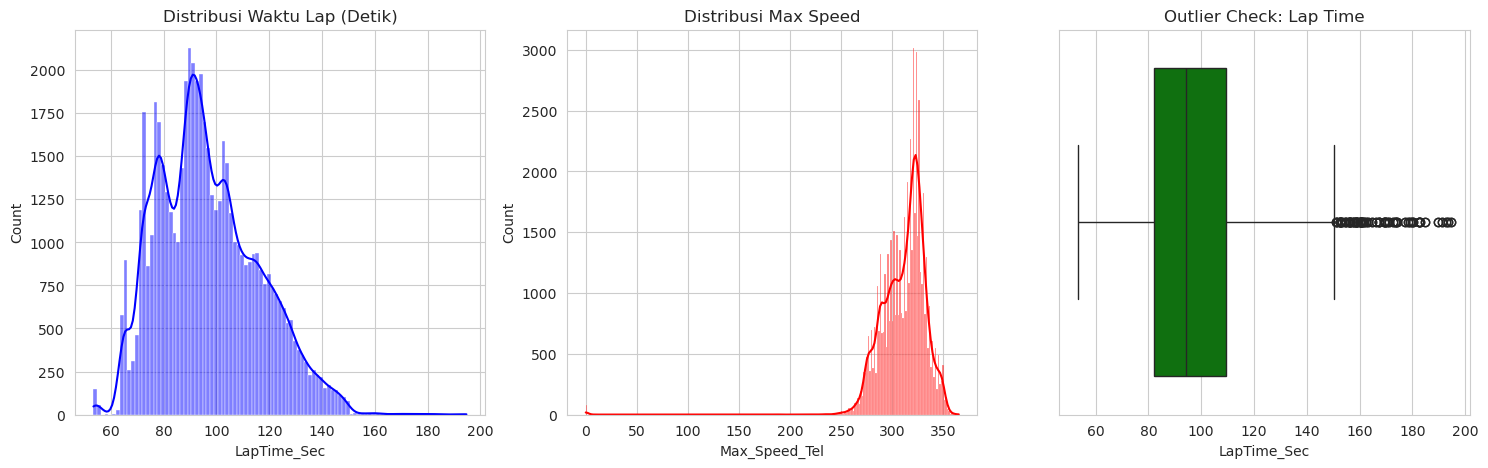

In [5]:
print("\n 2. UNIVARIATE ANALYSIS")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribusi Lap Time
sns.histplot(df['LapTime_Sec'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribusi Waktu Lap (Detik)')

# Distribusi Top Speed
sns.histplot(df['Max_Speed_Tel'], kde=True, ax=axes[1], color='red')
axes[1].set_title('Distribusi Max Speed')

# Boxplot Outlier Detection
sns.boxplot(x=df['LapTime_Sec'], ax=axes[2], color='green')
axes[2].set_title('Outlier Check: Lap Time')
plt.show()


3. BIVARIATE ANALYSIS


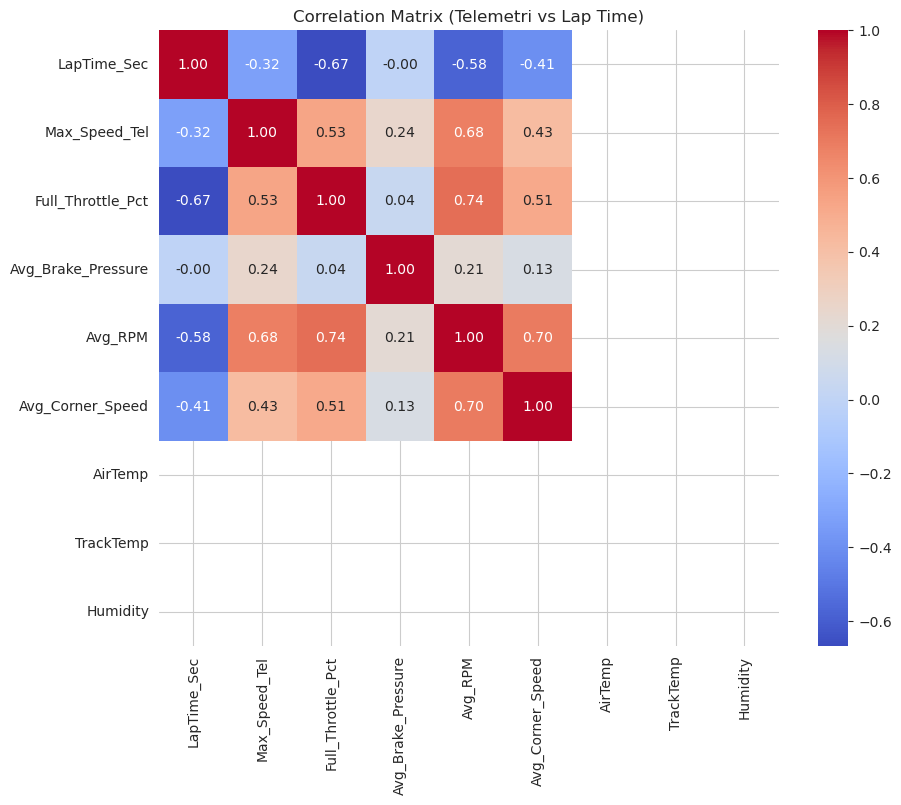

In [7]:
print("\n3. BIVARIATE ANALYSIS")

# UPDATE NAMA KOLOM KE VERSI RAW DATA
cols_corr = ['LapTime_Sec', 'Max_Speed_Tel', 'Full_Throttle_Pct', 'Avg_Brake_Pressure', 
             'Avg_RPM', 'Avg_Corner_Speed', 'AirTemp', 'TrackTemp', 'Humidity']

plt.figure(figsize=(10, 8))
sns.heatmap(df[cols_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Telemetri vs Lap Time)")
plt.show()


4. MULTIVARIATE ANALYSIS (PCA)


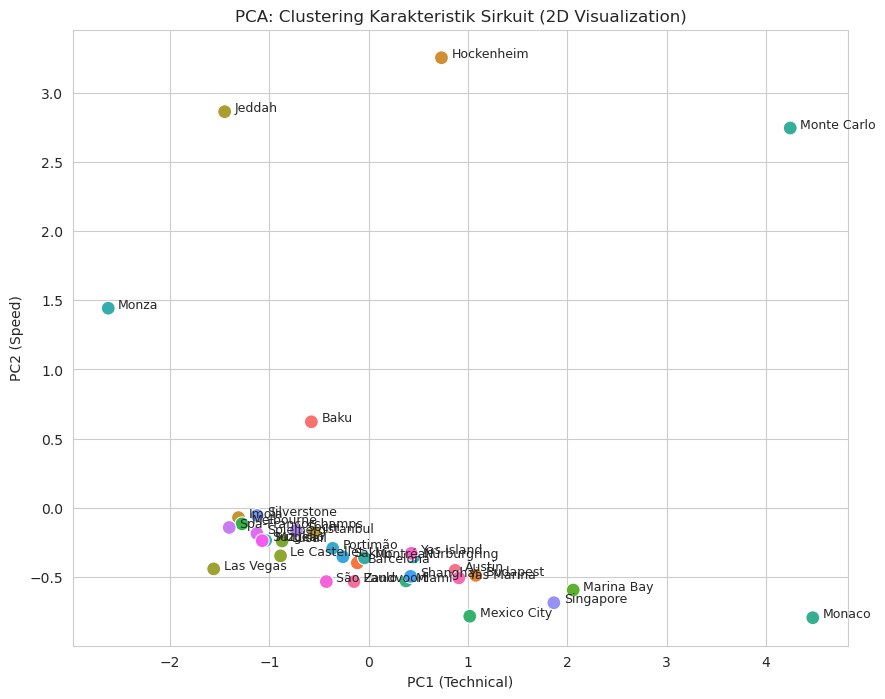

In [8]:
print("\n4. MULTIVARIATE ANALYSIS (PCA)")

# Pilih Fitur untuk Clustering
features = ['Full_Throttle_Pct', 'Avg_Brake_Pressure', 'Avg_Corner_Speed', 'Max_Speed_Tel']

x = df.groupby('Circuit')[features].mean().dropna()
x_scaled = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1 (Technical)', 'PC2 (Speed)'])
pca_df['Circuit'] = x.index

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1 (Technical)', y='PC2 (Speed)', s=100, hue='Circuit', legend=False)

# Labeling
for i in range(pca_df.shape[0]):
    plt.text(pca_df.iloc[i]['PC1 (Technical)']+0.1, pca_df.iloc[i]['PC2 (Speed)'], 
             pca_df.iloc[i]['Circuit'], fontsize=9)

plt.title("PCA: Clustering Karakteristik Sirkuit (2D Visualization)")
plt.grid(True)
plt.show()

In [11]:
print("\n6. STATISTICAL TESTING (ANOVA)")

# 1. Cek Kolom Mana yang Ada Isinya (TrackTemp atau AirTemp)
if df['TrackTemp'].count() > 10:
    col_to_test = 'TrackTemp'
    print("Menggunakan data TrackTemp (Suhu Trek)")
elif df['AirTemp'].count() > 10:
    col_to_test = 'AirTemp'
    print("TrackTemp kosong. Menggunakan AirTemp (Suhu Udara) sebagai pengganti.")
else:
    col_to_test = None
    print("Data Suhu (Track/Air) tidak tersedia/kosong. Skip ANOVA.")

# 2. Jalankan Tes Jika Data Ada
if col_to_test:
    # Buat DataFrame sementara yang bersih dari NaN
    df_clean = df.dropna(subset=[col_to_test, 'Max_Speed_Tel']).copy()
    
    # Bagi suhu jadi 3 kategori
    df_clean['Temp_Category'] = pd.cut(df_clean[col_to_test], bins=3, labels=['Cold', 'Medium', 'Hot'])

    # Siapkan Grup Data
    groups = [df_clean[df_clean['Temp_Category'] == cat]['Max_Speed_Tel'] for cat in ['Cold', 'Medium', 'Hot']]
    
    # Pastikan setiap grup ada isinya
    if all(len(g) > 0 for g in groups):
        f_stat, p_val = stats.f_oneway(*groups)

        print(f"\nANOVA Test Result ({col_to_test} vs Max Speed):")
        print(f"F-Statistic: {f_stat:.2f}")
        print(f"P-Value: {p_val:.5f}")

        if p_val < 0.05:
            print("Kesimpulan: Suhu MEMILIKI pengaruh signifikan terhadap Top Speed.")
        else:
            print("Kesimpulan: Suhu TIDAK berpengaruh signifikan.")
            
        # Visualisasi Tambahan Biar Keren
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_clean, x='Temp_Category', y='Max_Speed_Tel', palette='coolwarm')
        plt.title(f"Distribusi Top Speed berdasarkan {col_to_test}")
        plt.show()
    else:
        print("Data tidak cukup tersebar untuk dibagi 3 kategori.")


6. STATISTICAL TESTING (ANOVA)
Data Suhu (Track/Air) tidak tersedia/kosong. Skip ANOVA.
